In [1]:
%pip install fabio
%pip install pyFAI
%pip install glob2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os
import fabio
import matplotlib.pyplot as plt
import pandas as pd
import pyFAI
import glob
import re

from pyFAI.multi_geometry import MultiGeometry
from pyFAI.gui import jupyter
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator as AzInt
import scipy.io

## function below is CURRENTLY HARD CODED FOR PILATUS IMAGES

In [3]:
def load_image(imageFullname):
    """
    author: Fang Ren (SSRL), Robert Tang-Kong
    version: 1.1

    returns: numpy array with image data
    CURRENTLY HARD CODED FOR PILATUS
    """
    # get extension to consider
    ext = os.path.splitext(imageFullname)[1]
    #print(imageFullname)
    imArray = np.array([])
    if ext.lower() in ['.tif', '.tiff']:
        # open tiff image
        im = fabio.open(imageFullname)
        # input image object into a numpy array
        imArray = im.data
    elif ext.lower() in ['.raw']:
        # extract raw file
        im = open(imageFullname, 'rb')
        arr = np.fromstring(im.read(), dtype='int32')
        im.close()

        #raw requires prompting for dimensions, hard code for now
        arr.shape = (195, 487)
        imArray = np.array(arr)

    return imArray

## Initialize paths. 
*  Assumes images are in a subdirectory of the spec-path
*  Assumes export directory exists (try creating one programatically?)
*  Uses spec file to translate detector
*  Only tested for pliatus 100k in horizontal orientation

In [6]:
exportPath = "C:\\BL_June2021\\HZO\\HZO\\images\\export"
specPath = "C:\\BL_June2021\\HZO\\HZO\\"
specFiles = glob.glob(specPath + '*.csv') # use re to be more precise
specs = [pd.read_csv(x, index_col=0).rename(columns=lambda x: x.strip()) for x in specFiles]
user = 'b_mehta_'
imgPath = os.path.join(specPath, 'images')

## for Feb centerPx1, centerPx2 = (236, 91) 
# portrait mode?
portrait = True

# define detector.  
det = pyFAI.detectors.Pilatus100k()

# define detector geometry
centerPx1, centerPx2 = (236, 91) 
rot3 = 0
if portrait:
    centerPx2, centerPx1 = centerPx1, centerPx2
    rot3 = np.pi/2 

In [7]:
specs

[       TwoTheta  Detector  Monitor  Seconds     I0    I2  Foils  Normalized  \
     #                                                                         
 0         20.00         0   108055      4.0  80546  3568      0    0.000028   
 1         20.04         0   108171      4.0  93492  3569      0    0.000000   
 2         20.08         1   108360      4.0  93498  3565      0    0.000000   
 3         20.12         0   108244      4.0  93324  3565      0    0.000000   
 4         20.16         0   108330      4.0  93352  3560      0    0.000009   
 ...         ...       ...      ...      ...    ...   ...    ...         ...   
 1246      69.84         0   108625      4.0  93622  3623      0    0.000018   
 1247      69.88         0   108868      4.0  93821  3622      0    0.000018   
 1248      69.92         1   109054      4.0  93969  3618      0    0.000009   
 1249      69.96         0   108881      4.0  93813  3620      0    0.000009   
 1250      70.00         1   108866     

Processing gi0p2_HZO_scan1 ==================================
--reading images for gi0p2_HZO_scan1


C:\Users\balsa\anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


--saving plots, results for gi0p2_HZO_scan1


C:\Users\balsa\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
C:\Users\balsa\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log


--exporting data for gi0p2_HZO_scan1


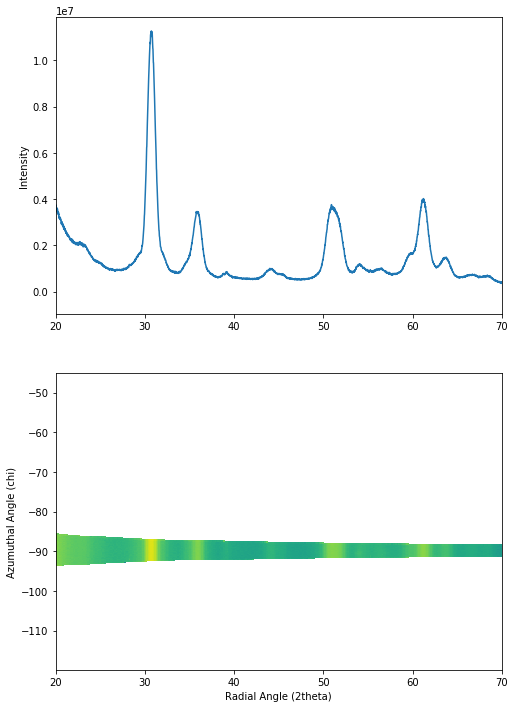

Processing gi0p5_HZO_scan1 ==================================
--reading images for gi0p5_HZO_scan1


C:\Users\balsa\anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


--saving plots, results for gi0p5_HZO_scan1


C:\Users\balsa\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
C:\Users\balsa\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log


--exporting data for gi0p5_HZO_scan1


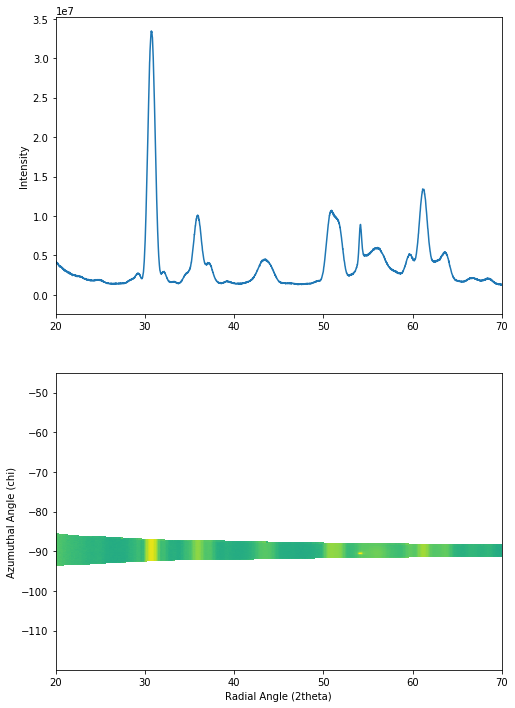

In [7]:
# Iterate through files in folder
for i in range(len(specFiles)):
    exptName, ext = os.path.splitext(os.path.basename(specFiles[i]))
    imgFiles = glob.glob(os.path.join(imgPath, user+exptName+'*.raw'))
    
    specPath = specFiles[i]
    spec = pd.read_csv(specPath)
    spec.rename(columns=lambda x: x.strip(), inplace=True)
    
    imgs = []
    ais = []
    print('Processing {} =================================='.format(exptName))
    print('--reading images for {}'.format(exptName))
    
    if not imgFiles:
        print('no image files found')
        continue
    
    
    for rawPath in imgFiles:
        # Append img to list of images
        img = load_image(rawPath)
        
        imgs.append(img)

        # Append calibrated ai to list of ai's
        scanNo = int(re.search('(\d{4})(\.raw)', rawPath).group(1))
        ai = AzInt(dist=0.714751, poni1=centerPx1*det.pixel1, poni2=centerPx2*det.pixel1, detector=det, 
               wavelength=7.2932E-11, rot1=np.pi/180*float(spec['TwoTheta'][scanNo]), rot3=rot3)
        ais.append(ai)

    # This is probably too much    
    # resultDict[exptName] = (imgs, ais)
    
    print('--saving plots, results for {}'.format(exptName))
    
    mg = MultiGeometry(ais, unit="2th_deg", radial_range=(0, 150), azimuth_range=(-120,-45))
    fig, ax = plt.subplots(2, 1, figsize=(8,12))

    int1d = mg.integrate1d(imgs, 10000)
    ax[0].plot(int1d[0], int1d[1])
    ax[0].set_ylabel('Intensity')
    ax[0].set_xlim(20,70)

    res2d = mg.integrate2d(imgs, 1000,360)
    # gives 3 arrays.  First is intensities with shape (arg2, arg1)  Second is 2th range, third is azimuthal range

    ax[1].pcolormesh(res2d[1], res2d[2], np.log(res2d[0]), cmap = 'viridis')

    ax[1].set_xlim(20,70)
    ax[1].set_xlabel('Radial Angle (2theta)')

    ax[1].set_ylabel('Azumuthal Angle (chi)')

    plt.savefig(exportPath + exptName + '_figures.png')

    print('--exporting data for {}'.format(exptName))
    int1List = list(int1d)
    int1df = pd.DataFrame(data=int1List[1], index=int1List[0])
    int1df.to_csv(exportPath + exptName + '_1D_2nd.csv')

    scipy.io.savemat(exportPath+exptName+'_Qchi.mat', {'Q':res2d[1], 'chi':res2d[2], 'cake':res2d[0]})
    
    plt.show()


In [27]:
testPath = os.path.join(imgPath, 'b_mehta_calibration_directbeam_4Nov2020_scan1_0050.raw')
print(testPath)
img = load_image(testPath)
plt.imshow(np.rot90(img, k=-1))
plt.scatter(95, 237, c='r')

C:\Users\roberttk\Desktop\SLAC_RA\DATA\2-1_calibration_test\JL02\images\b_mehta_calibration_directbeam_4Nov2020_scan1_0050.raw


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\roberttk\\Desktop\\SLAC_RA\\DATA\\2-1_calibration_test\\JL02\\images\\b_mehta_calibration_directbeam_4Nov2020_scan1_0050.raw'